In [1]:
import numpy as np

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline

# import sys
# sys.path.append('../') # Add the course directory to the Python path
# import cphy.plotting as cplot



In [16]:
eq.chi

1.0

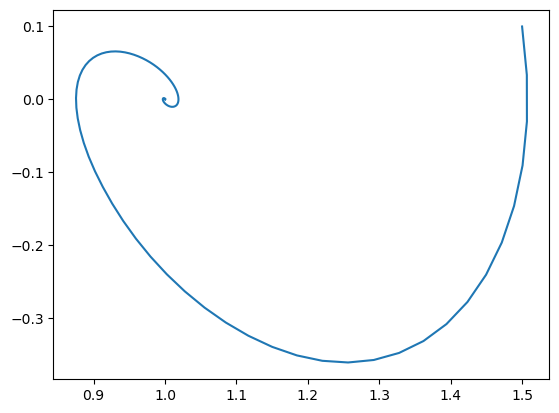

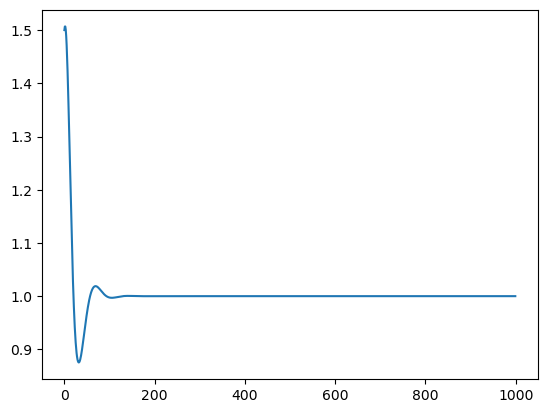

In [34]:

# from scipy.integrate import solve_ivp

# class AlveoliModel:
#     """

#     The cubic term represents a nonlinear elastic response
#     Bistability: collapsed state and open state

#     CRPG: pattern generator
#     Alveoli model: elastic response function
#     """

#     def __init__(self, alpha=1, beta=1, omega=1, gamma=0.1):
#         self.alpha = alpha
#         self.beta = beta
#         self.omega = omega
#         self.gamma = gamma
#         self.chi = np.sqrt(self.beta / self.alpha)

#     def rhs(self, t, X):
#         # duffing
#         #r ̈+ βr + αr3 + (δ − r)r ̇ = γ cos(ωt)
#         r, v, z = X
#         zdot = self.omega
#         rdot = v

#         force = self.gamma * np.cos(z)
#         rs = (r - self.chi)
#         #vdot = force - -self.beta * rs - self.alpha * rs ** 3 - (2 * self.chi - r) * v 
#         vdot = force - self.beta * rs - self.alpha * rs ** 3 - (2 * self.chi - r) * v 

#         return np.array([rdot, vdot, zdot])
    
#     def solve(self, t, X0):
#         self.t = t
#         self.X0 = X0
#         self.sol = solve_ivp(self.rhs, (t[0], t[-1]), X0, t_eval=t)
#         return self.sol

# # No forcing
# eq = AlveoliModel(gamma=0)

# t = np.linspace(0, 100, 1000)
# X0 = np.array([1.5, 0.1, 0])
# sol = eq.solve(t, X0)

# plt.figure()
# plt.plot(sol.y[0, :], sol.y[1, :])

# plt.figure()
# plt.plot(sol.y[0, :])

/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_56033/1195384719.py:30: RuntimeWarning: overflow encountered in double_scalars
  rdot += -self.alpha * rs ** 3 + self.beta * rs # elastic response


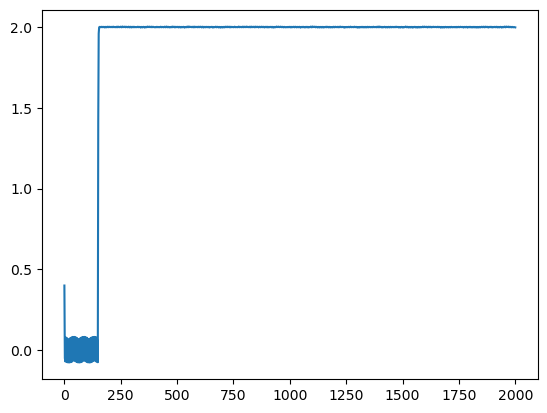

In [86]:

from scipy.integrate import solve_ivp

class AlveoliModel:
    """

    The cubic term represents a nonlinear elastic response
    Bistability: collapsed state and open state

    CRPG: pattern generator
    Alveoli model: elastic response function
    """

    def __init__(self, alpha=1, beta=1, omega=1, gamma=0.1):
        self.alpha = alpha
        self.beta = beta
        self.omega = omega
        self.gamma = gamma
        self.rc = np.sqrt(self.beta / self.alpha)

    def rhs(self, t, X):
        # duffing
        r, v, z = X
        zdot = self.omega
        # rdot = v

        force = self.gamma * np.cos(z)
        rs = r - self.rc
        rdot = 0.01 * force / r**3
        rdot += -self.alpha * rs ** 3 + self.beta * rs # elastic response
        vdot = 0

        return np.array([rdot, vdot, zdot])
    
    def solve(self, t, X0):
        self.t = t
        self.X0 = X0
        self.sol = solve_ivp(self.rhs, (t[0], t[-1]), X0, t_eval=t)
        return self.sol

# No forcing
# eq = AlveoliModel(gamma=0)
eq = AlveoliModel()

t = np.linspace(0, 200, 1000)
X0 = np.array([0.4, 1.3, 0])
sol = eq.solve(t, X0)

# plt.figure()
# plt.plot(sol.y[0, :], sol.y[1, :])

plt.figure()
plt.plot(sol.t, sol.y[0, :])

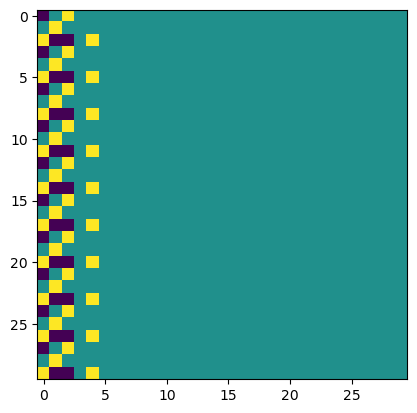

In [53]:
# import numpy as np

import numpy as np

def trinary_add(a, b):
    return (a + b) % 3 - 1

def generate_trinary_row(n, seed):
    trinaryArray = np.zeros(n, dtype=int)
    
    # Seed initial non-zero values deterministically based on the seed value
    trinaryArray[0] = seed % 3 - 1
    trinaryArray[1] = (seed + 1) % 3 - 1
    
    for i in range(2, n):
        # Make it sparse: Only update if at least one of the preceding indices is non-zero
        if trinaryArray[i-1] != 0 or trinaryArray[i-2] != 0:
            trinaryArray[i] = trinary_add(trinaryArray[i-1], trinaryArray[i-2])
    
    return trinaryArray

def generate_trinary_matrix(rows, cols):
    trinaryMatrix = np.zeros((rows, cols), dtype=int)
    for i in range(rows):
        trinaryMatrix[i, :] = generate_trinary_row(cols, i)
        
    return trinaryMatrix



plt.imshow(generate_trinary_matrix(30, 30))





In [ ]:
from itertools import product

def get_random_tritop(n, k=None):
    """
    Return a fixed random function that takes n trits and returns 1 trit. The function 
    does not necessarily use all n trits that it is given
    """
    if k is None:
        k = n
    # number of input trits
    assert k <= n, "k must be less than or equal to n"

    input_inds = np.random.choice(n, k, replace=False)
    
    # def random_tritop(trit_list):
        # return np.sum(trit_list[input_inds]) % 3 - 1

    coeff = np.random.choice([-1, 1], len(input_inds))
    def random_tritop(trit_list):
        selected_trits = trit_list[input_inds]
        
        # Use a higher-order binomial expression to increase sparsity
        result = np.dot(coeff, selected_trits)  # (x + y)^3
        # result2 = np.prod(coeff2 * selected_trits)  # (x + y)^3

        # result = result2

        if result == 3:
            return 1
        if result == -3:
            return -1
        else:
            return 0
        
        return result % 3 - 1

    return random_tritop

    


def generate_clauses(N, Q):
    assert Q < N, "Q must be less than N"

    output_funcs = []
    for _ in range(N - Q):
        output_funcs.append(get_random_tritop(Q, k=3))

    # Generate all combinations of Q trits
    for trit_combination in product([-1, 0, 1], repeat=Q):
        trit_list = list(trit_combination)

        # Apply deterministic operations for N - Q remaining trits
        for i in range(N - Q):
            next_trit = output_funcs[i](np.array(trit_list))
            trit_list.append(next_trit)

        yield trit_list

def generate_all_clauses(N, Q, randomize=True):
    all_clauses = []
    for clause in generate_clauses(N, Q):
        all_clauses.append(clause)

    if randomize:
        np.random.shuffle(all_clauses)
    return all_clauses

# Example usage
N = 50
Q = 5
h = np.array(generate_all_clauses(N, Q))

np.median(np.sum(np.abs(h), axis=1))
